## The Team - Les Perchistes 🌴🦧

- Marin Philipe $\Longrightarrow$ Robot control 👨‍💻
- Neil Chadli $\Longrightarrow$ Path finding 🔍
- Loïc Delineau $\Longrightarrow$ Computer Vision 🕵️
- Matthieu Scharffe $\Longrightarrow$ Kalman Filter 🚀

# Introduction


<img src="./img/thymio.gif" alt="Little animation of Thymio" style="display: block;
  margin-left: auto;
  margin-right: auto;
  width: 40%;"/>

## Project Description

The objective of this project is to navigate the Thymio robot from a starting point to a designated endpoint, overcoming obstacles represented by black shapes along its path. The robot must also be capable of responding to unexpected obstacles that appear in its trajectory. An overhead camera will be used to calculate the robot's path and determine its location. Additionally, we aim to ensure that the Kalman filter can accurately localize the robot both with and without the camera.

# Setup

We chose DLLEL as our testing ground and constructed a mount to hold our camera. The mount is securely attached to the fences on the first floor, providing an optimal view of the white table where the robot operates. We utilize Aruco tags for normalization and pose estimation. Black shapes representing obstacles for the Thymio robot to avoid have been drawn and can be found in the *obstacles* folder. The picture below offers an overview of our setup.

![Picture of the overall setup](./img/Dispositif.jpeg)

## Software

The code is entirely written in python. The libraries used are the following :

- Numpy
- OpenCV == 4.6.0
- Matplotlib
- json
- sys
- time
- Brensenham
- scipy
- heapq

In [206]:
### Importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import cv2
import json 
import sys
import time
from bresenham import bresenham
from scipy.ndimage import gaussian_filter
from heapq import heappush, heappop

## Measurements

The measurements used to localized the thymio come from the computer vision and the speed sensors of the robot.

## Parametrization of the problem

![Parametrization of the problem](./img/repere.png)

The studied problem is composed of 2 basis and 3 frames. The main frame $\mathcal{R}_0 = (O,\overrightarrow{x_0}, \overrightarrow{y_0}, \overrightarrow{z_0})$ is defined as so : 

- The origin of the frame $(O)$ is in the top left corner of the image.
- The axis $(O,\overrightarrow{x_0})$ goes from left to right over the upper border.
- The axis $(O,\overrightarrow{y_0})$ goes from top to bottom over the left border.
- The axis $(O,\overrightarrow{z_0})$ points toward the ground.

Let's define the point $T$ as the middle point of the wheels. $I_g$ (resp. $I_d$) is the contact point of the left wheel (resp. right). $L$ is the distance between $T$ and $I_g$ or $I_d$. We can define the second frame $\mathcal{R}_2 = (T,\overrightarrow{x_1}, \overrightarrow{y_1}, \overrightarrow{z_0})$.

- The axis $(T,\overrightarrow{x_1})$ is along the median of $[I_g,I_d]$ toward the front of the robot. 
- The axis $(T,\overrightarrow{y_1})$ goes from $T$ to $I_d$.


Let's define the third frame where some derivations will be made : $\mathcal{R}_1 = (0,\overrightarrow{x_1}, \overrightarrow{y_1}, \overrightarrow{z_0})$. $\theta$ is defined as rotation angle between basis 0 and basis 1. It is important to note that to go from basis 0 to 1, the rotation matrix is :

$$
    \begin{pmatrix} x_1\\ y_1 \end{pmatrix} = \underbrace{\begin{pmatrix} \cos{\theta} & \sin{\theta}\\ -\sin{\theta} & \cos{\theta} \end{pmatrix}}_{R(\theta)} \begin{pmatrix} x_0\\ y_0 \end{pmatrix}
$$

In [207]:
def Rotation_theta(theta):
    return np.array([[np.cos(theta), np.sin(theta)],
                     [-np.sin(theta), np.cos(theta)]])

### Kinematic/Dynamic of the system

Positions :

$$
\begin{aligned}
    \overrightarrow{OT} &= x \  \overrightarrow{x_0} + y \  \overrightarrow{y_0} \\
    &= x_1 \  \overrightarrow{x_1} + y_1 \  \overrightarrow{y_1}
\end{aligned}
$$

Speeds :

$$
\begin{aligned}    
    \overrightarrow{V(T,1/0)} &= \left( \dot x_1 - \dot{\theta} y_1 \right) \  \overrightarrow{x_1} + \left(\dot y_1 + \dot \theta x_1 \right) \  \overrightarrow{y_1} \\
    \overrightarrow{V(I_d,1/0)} &= \left( \dot x_1 - \dot{\theta} y_1 - \dot \theta L \right) \  \overrightarrow{x_1} + \left(\dot y_1 + \dot \theta x_1 \right) \  \overrightarrow{y_1} \\
    \overrightarrow{V(I_g,1/0)} &= \left( \dot x_1 - \dot{\theta} y_1 + \dot \theta L \right) \  \overrightarrow{x_1} + \left(\dot y_1 + \dot \theta x_1 \right) \  \overrightarrow{y_1}
\end{aligned}
$$

The quantities that the robot measures and controls are the following :

$$
\left\{
\begin{aligned}
    V_{I_d} &= \overrightarrow{V(I_d,1/0)} . \overrightarrow{x_1} = \dot x_1 - \dot{\theta} y_1 - \dot \theta L \\
    V_{I_g} &= \overrightarrow{V(I_g,1/0)} . \overrightarrow{x_1} = \dot x_1 - \dot{\theta} y_1 + \dot \theta L
\end{aligned} \right. \Leftrightarrow
\left\{
\begin{aligned}
    \frac{V_{I_g} + V_{I_d}}{2} & = \dot x_1 - \dot{\theta} y_1 = \dot x \cos{\theta} + \dot y \sin{\theta}\\
    \frac{V_{I_g} - V_{I_d}}{2} &= \dot \theta L
\end{aligned} \right.
$$

### Dimensions of the parameters

To make sure that we don't have an interface problem, we paid attention to the units of the used quantities. We paid attention to the measurements of the Thymio which are in its own unit system. So we took a special care for them. We convert them.

- The coordinates $(x,y)$ are in mm
- The angle $(\theta)$ is in radian
- The speeds $(\dot x, \dot y)$ are in mm/s
- The angular speeds $(\dot \theta)$ are in rad/s



# Computer vision

The first step of computer vision has been to compute the intrinsic parameters of the camera following [OpenCV tutorial](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html). The file *calib_camera.py* in the folder $vision$ is in charge of that. It stores the parameters in the file *camera_calibration.json$* Let's what happens on one of the checkerboard images that we took.

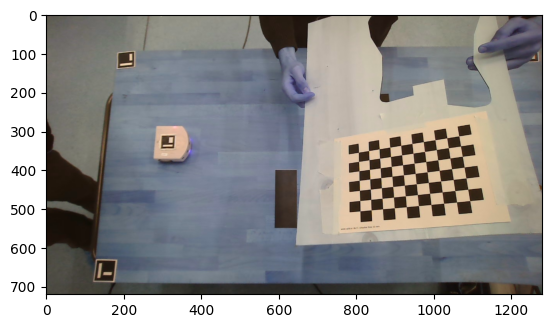

In [208]:
checkerboard_image = cv2.imread('./vision/checkerboard_images/frame15.jpg')

plt.imshow(checkerboard_image)

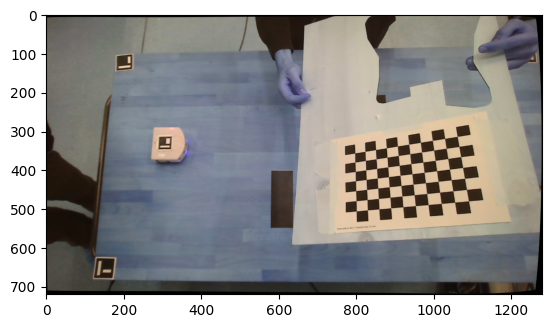

In [209]:
### Loading camera parameters

#depends on camera port
#portID = 0
#cap = cv2.VideoCapture(portID)
with open('./vision/camera_calibration.json', 'r') as file:
       params = json.load(file)
   
camera_matrix = np.array(params["camera_matrix"], dtype=np.float32)
dist_coeffs = np.array(params["distortion_coefficients"], dtype=np.float32)

### Computing the new camera matrix
h,  w = checkerboard_image.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w,h), 1, (w,h))

### Undistorting and displaying the image
check_img_undist = cv2.undistort(checkerboard_image, camera_matrix, dist_coeffs, None, newcameramtx)
plt.imshow(check_img_undist)

Since the camera has very little distortion, the undistorted image looks very similar to the distort one. One can see the black lines at the bottom and on the right due to the undistortion. Now let's work on an image of the playground.

**note:** this report currently is made using an image of a wooden table, you can also run it using a white table. to do so, uncomment the 2nd line of the following cell, and comment the first one

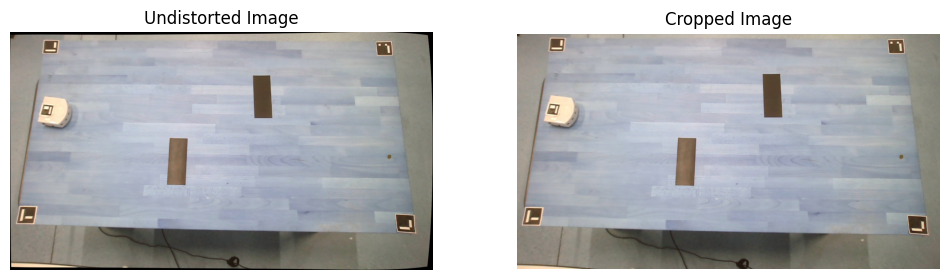

In [210]:
frame = cv2.imread('./img/table.jpg')
#frame = cv2.imread('./img/table2.jpg')
# undistort
h,  w = frame.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w,h), 1, (w,h))
dst = cv2.undistort(frame, camera_matrix, dist_coeffs, None, newcameramtx)

# crop the image
x, y, w, h = roi
frame = dst[y:y+h, x:x+w]

# Display the images side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(dst)
axes[0].set_title('Undistorted Image')
axes[0].axis('off')
axes[1].imshow(frame)
axes[1].set_title('Cropped Image')
axes[1].axis('off')
plt.show()

Now we can normalize the image to compute the costmap using the ArUco markers put at the corners of the table.

[INFO] Detecting 'DICT_ARUCO_ORIGINAL' markers...


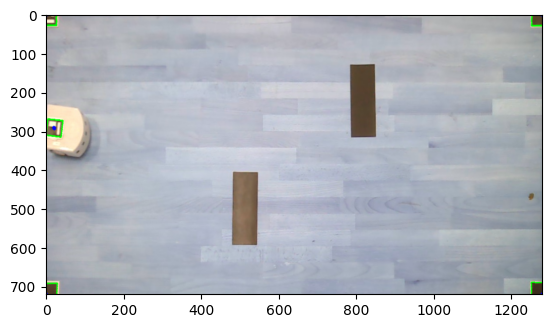

In [211]:
desired_aruco_dictionary = "DICT_ARUCO_ORIGINAL"

# The different ArUco dictionaries built into the OpenCV library
ARUCO_DICT = {
    "DICT_4X4_50": cv2.aruco.DICT_4X4_50,
    "DICT_4X4_100": cv2.aruco.DICT_4X4_100,
    "DICT_4X4_250": cv2.aruco.DICT_4X4_250,
    "DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
    "DICT_5X5_50": cv2.aruco.DICT_5X5_50,
    "DICT_5X5_100": cv2.aruco.DICT_5X5_100,
    "DICT_5X5_250": cv2.aruco.DICT_5X5_250,
    "DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
    "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
    "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
    "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
    "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
    "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
    "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
    "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
    "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
    "DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
}


if ARUCO_DICT.get(desired_aruco_dictionary, None) is None:
    print(f"[INFO] ArUCo tag of '{desired_aruco_dictionary}' is not supported")
    sys.exit(0)
print(f"[INFO] Detecting '{desired_aruco_dictionary}' markers...")
aruco_dict = cv2.aruco.Dictionary_get(ARUCO_DICT[desired_aruco_dictionary])
aruco_params = cv2.aruco.DetectorParameters_create()
square_corners = []
tag_positions = {1: (0, 0), 2: (0, 0), 3: (0, 0), 4: (0, 0)}
 # Detect ArUco markers
corners, ids, _ = cv2.aruco.detectMarkers(frame, aruco_dict, parameters=aruco_params)

if len(corners) == 5:
    ids = ids.flatten()
    for marker_corner, marker_id in zip(corners, ids):
        marker_corner = marker_corner.reshape((4, 2))
        top_left, top_right, bottom_right, bottom_left = [tuple(map(int, corner)) for corner in marker_corner]
        # Draw bounding box
        cv2.line(frame, top_left, top_right, (0, 255, 0), 2)
        cv2.line(frame, top_right, bottom_right, (0, 255, 0), 2)
        cv2.line(frame, bottom_right, bottom_left, (0, 255, 0), 2)
        cv2.line(frame, bottom_left, top_left, (0, 255, 0), 2)
        # Draw center
        center_x = int((top_left[0] + bottom_right[0]) / 2.0)
        center_y = int((top_left[1] + bottom_right[1]) / 2.0)
        cv2.circle(frame, (center_x, center_y), 4, (0, 0, 255), -1)
       
        tag_positions[marker_id] = (center_x, center_y)
    # Warp perspective if all 4 markers are detected
    if all(tag_positions.values()):
        square_corners = np.array(
            [tag_positions[1], tag_positions[2], tag_positions[3], tag_positions[4]]
        ).astype(np.float32)
        output_corners = np.array([[0, 0], [1280, 0], [1280, 720], [0, 720]]).astype(np.float32)
        matrix = cv2.getPerspectiveTransform(square_corners, output_corners)
        normalized_image = cv2.warpPerspective(frame, matrix, (1280, 720))
        
plt.imshow(normalized_image)


To get the costmap, we have to binarize the image to highlight the black obstacles. Just before the binarization, we draw a white circle around the Thymio so it does not create any problem. To binarize the image, we first convert it to grayscale using cv2.cvtColor, then we apply a threshold using cvt.threshold. This threshold is empirical an we got it by experimentation, it can vary depending on the light.

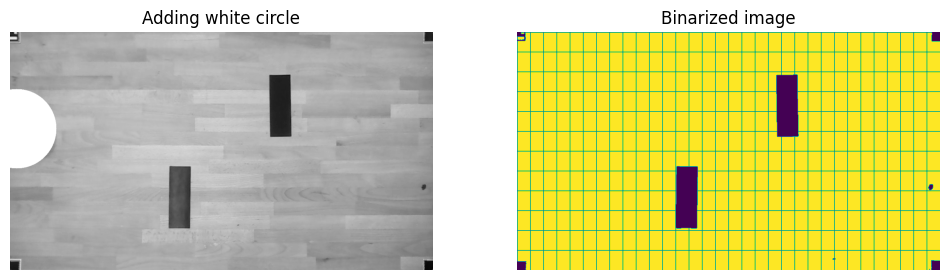

In [212]:
### Getting Thymio's position
# we want the new position of tag 5
tag5_pos = tag_positions[5]
tag5_pos = np.array(tag5_pos).astype(np.float32)
warped_tag5_pos = cv2.perspectiveTransform(np.array([tag5_pos]).reshape(-1, 1, 2), matrix)[0][0] #this is the position of the Thymio
#adding a circle to the new position of tag 5 to hide it from thresholding
normcopy = normalized_image.copy()
cv2.circle(normcopy, (int(warped_tag5_pos[0]),int(warped_tag5_pos[1])), 120, (255, 255, 255), -1)

### Binarizing the image
# Converting to grayscale
gray_image = cv2.cvtColor(normcopy, cv2.COLOR_BGR2GRAY)

# Thresholding
ret,thresh1 = cv2.threshold(gray_image,127,255,cv2.THRESH_BINARY)

thresh1_copy = thresh1.copy()

### Adding the grid on the image
rows,cols = (12,32)
# we have rows and cols we want to draw them on the image
cm_per_row = thresh1_copy.shape[0] / rows
cm_per_col = thresh1_copy.shape[1] / cols

for i in range(0, rows):
    cv2.line(thresh1_copy, (0, int(i * cm_per_row)), (thresh1_copy.shape[1], int(i * cm_per_row)), (0, 255, 0), 1)
    
for i in range(0, cols):
    cv2.line(thresh1_copy, (int(i * cm_per_col), 0), (int(i * cm_per_col), thresh1_copy.shape[0]), (0, 255, 0), 1)


# Display the images side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title('Adding white circle')
axes[0].axis('off')
axes[1].imshow(thresh1_copy)
axes[1].set_title('Binarized image')
axes[1].axis('off')
plt.show()

Now it is to compute the costmap i.e. converting the binarized image to a numpy array. For this purpose, we created a function *create_costmap* that first erodes the image to make the obstacles bigger and then computes the mean value of each block and decide based on a threshold if it is an obstacle or not. Once again, the value of this threshold may vary depending on the light.

 time taken to threshold the image: 0.001999378204345703
(12, 60, 32, 40)
(12, 32)
The costmap shape is: (12, 32)
 time taken to recreate the binary image: 0.011614322662353516


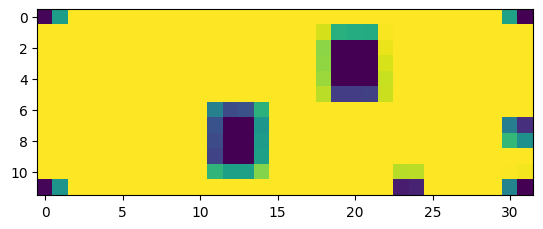

In [213]:
def create_costmap(image, grid_rows, grid_cols):
    """
    Discretize the image into a costmap and display the binary image.
    """
    start_time = time.time()
    # Binarize the image
    
    _, binary_image = cv2.threshold(image, 70, 255, cv2.THRESH_BINARY)

    # Erosion operation to make the obstacles bigger
    kernel = np.ones((5, 5), np.uint8)
    binary_image = cv2.erode(binary_image, kernel,iterations=16)

    height, width = image.shape
    block_height = height // grid_rows
    block_width = width // grid_cols
    
    print(f" time taken to threshold the image: {time.time() - start_time}")

    # Reshape the image into blocks
    
    reshaped = binary_image.reshape(grid_rows, block_height,  grid_cols, block_width)
    print(reshaped.shape)
    averages = np.mean(reshaped, axis=(1, 3))
    
    
    print(averages.shape)
    plt.imshow(averages)

    # Generate the costmap based on the average threshold
    costmap = np.where(averages > 200, 0, 1)
    
    
    print(f"The costmap shape is: {costmap.shape}")

    # Recreate binary image from costmap
    recreated_binary_image = np.kron(
        (1 - costmap).astype(np.uint8), np.ones((block_height, block_width), dtype=np.uint8)
    ) * 255
    
    print(f" time taken to recreate the binary image: {time.time() - start_time}")

    # Display the recreated binary image
    
    #plt.imshow(recreated_binary_image, cmap='gray')
    rec = np.kron(
        (1 - costmap).astype(np.uint8), np.ones((block_height, block_width), dtype=np.uint8)
    ) * 255


    return costmap, block_height, block_width,rec

costmap,block_height,block_width,rec = create_costmap(thresh1,12,32)

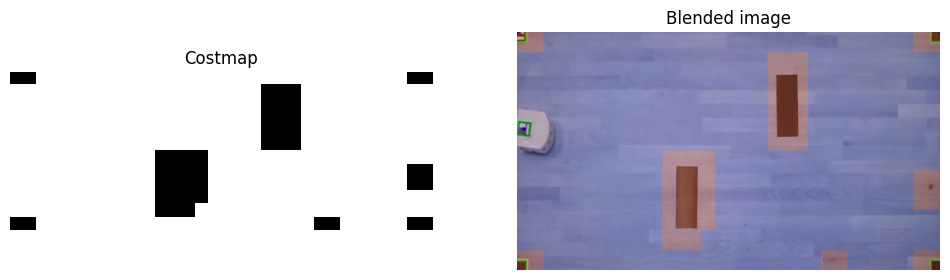

In [214]:
costmap_colored = cv2.applyColorMap(rec, cv2.COLORMAP_JET)
costmap_colored = cv2.resize(costmap_colored, (normalized_image.shape[1], normalized_image.shape[0]))
blended = cv2.addWeighted(normalized_image, 0.7, costmap_colored, 0.3, 0)

# Display the images side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(costmap, cmap='gray_r')
axes[0].set_title('Costmap')
axes[0].axis('off')
axes[1].imshow(blended)
axes[1].set_title('Blended image')
axes[1].axis('off')
plt.show()

**note:** the costmap for the white table is cleaner since there are less imperfections than on the wooden table.

# Path Finding

### A* Algorithm


  **Side note** : The A* algorithm is inspired by the course Multivariable Control taught by professor Giancarlo Ferrari Trecate. 🚀
  We chose to use A* with Manhattan distance, as it proved to be effective enough, and an euclidean path could come close to an obstacle vertex.

  ##### A* Algorithm for Shortest Path in a 2D Grid

  This implementation of the **A*** algorithm finds the shortest path from a starting point to a goal in a 2D grid represented by a **costmap** (where `0` indicates walkable cells and other values indicate obstacles).


  #### 1. Initialization
  - The algorithm starts with an **open set** (priority queue) initialized with the starting node.
  - Each node in the queue is represented as a tuple: `(f_cost, g_cost, position)`.
    - `g_cost` is the cost to reach the current node from the start.
    - `f_cost = g_cost + heuristic`, where the **heuristic** estimates the cost to the goal.



  #### 2. Heuristic Function
  - The heuristic used is the **Manhattan distance**, which calculates the sum of the absolute differences between the x and y coordinates of two points:
      $$
      h(a, b) = |a_x - b_x| + |a_y - b_y|
      $$
  - It approximates the cost to reach the goal.



  #### 3. Neighbors Function
  - For each node, its **neighbors** are the adjacent cells:
    - Up, down, left, right.
    - Within the grid bounds.
    - Walkable (`costmap[nx, ny] == 0`).


  #### 4. Main Loop
  - The algorithm explores nodes in the open set with the lowest `f_cost`.
  - For each node:
    1. Calculate the **tentative `g_cost`** for its neighbors.
    2. If the neighbor is unexplored or a cheaper path to it is found:
      - Update:
        - `came_from` (to track the path).
        - `g_cost` (actual cost from the start to the neighbor).
        - `f_cost` (for the priority queue).



  #### 5. Path Reconstruction
  - If the goal is reached:
    - Backtrack from the goal to the start using the `came_from` dictionary.
    - Reconstruct the shortest path.



  #### 6. Termination
  - The algorithm ends when:
    1. The goal is reached.
    2. The open set is empty, indicating no valid path exists.



  #### Summary of Algorithm Flow
  1. Start at the initial node.
  2. Explore neighbors and calculate `f_cost` for each.
  3. Gradually propagate through the grid, always prioritizing nodes closer to the goal.
  4. Once the goal is reached, reconstruct the shortest path.
  5. If the open set becomes empty, conclude that no path exists.




In [215]:
def heuristic(a, b):
    """
    Heuristic function for A* algorithm (Manhattan distance).
    """
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar(costmap, start, goal):
    """
    A* algorithm for shortest path.
    Saves the costmap at each step for debugging purposes.
    """
    print(f"start: {start}, goal: {goal}")
    rows, cols = costmap.shape
    open_set = []
    heappush(open_set, (0, 0, start))  # (f_cost, g_cost, position)
    came_from = {}
    g_costs = {start: 0}
    explored = set()

    def heuristic(a, b):
        # Using Manhattan distance as heuristic
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def neighbors(node):
        x, y = node
        x= int(x)
        y = int(y)
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and costmap[nx, ny] == 0:
                yield (nx, ny)

    step = 0
    while open_set:
        _, current_g_cost, current_pos = heappop(open_set)
        
        explored.add(current_pos)

        # Save the current costmap for debugging
        #plt.imsave(f'costmap_step_{step}.png', costmap, cmap='gray')
        step += 1

        if current_pos == goal:
            print(f"Goal reached at {current_pos}!")
            path = []
            while current_pos in came_from:
                path.append(current_pos)
                current_pos = came_from[current_pos]
            path.append(start)
            return path[::-1]  # Reverse path

        for neighbor in neighbors(current_pos):
            tentative_g_cost = g_costs[current_pos] + 1
            #print(f"neighbor: {neighbor}, tentative_g_cost: {tentative_g_cost}")
            if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                #print(f"neighbor: {neighbor}, tentative_g_cost: {tentative_g_cost}")
                came_from[neighbor] = current_pos
                g_costs[neighbor] = tentative_g_cost
                f_cost = tentative_g_cost + heuristic(neighbor, goal)
                heappush(open_set, (f_cost, tentative_g_cost, neighbor))
    print("No path found!")
    return []  # No path found


### Goal Selection

To let the user select a goal that the Thymio has to reach, we create a mouse callback function which is executed when a mouse event takes place. The following cell allows you to select a point as a goal by left clicking on your mouse. Then, to close the window, press the key 'q' on your computer.

In [216]:
# Global list to store the selected goal point
points = []

def select_goal_point(event, x, y, flags, param):
    """
    Mouse callback function to capture clicks for selecting the goal point.
    """
    global points
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 1:  # Allow only one point
        print(f"Goal point selected at: ({x}, {y})")  # Print the selected point
        points.append((y, x))  # Store the point as (row, col)
        # Draw a visual marker on the image at the selected point
        temp_image = param.copy()
        cv2.circle(temp_image, (x, y), 5, (0, 0, 255), -1)  # Red dot for the goal
        cv2.imshow("Select Goal", temp_image)

# Display the normalized image and allow goal selection
cv2.imshow("Select Goal", normalized_image)
cv2.setMouseCallback("Select Goal", select_goal_point, normalized_image)
print("Click on the image to select the goal point.")
print("Press 'q' to close the window.")

# Wait until the user presses 'q'
while True:
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Close window on pressing 'q'
        print("Exiting...")
        break

# Close the window after the user exits
cv2.destroyAllWindows()

if points:
    print(f"Selected goal point: {points[0]}")
else:
    print("No goal point selected!")

Click on the image to select the goal point.
Press 'q' to close the window.
Goal point selected at: (954, 186)
Exiting...
Selected goal point: (186, 954)


we can now convert this point in pixels coordinates to grid coordinates. The convention we use is to keep the origin in the top left corner and mark each cell as such: (row, col). 

In [217]:
# Compute start position in grid coordinates (using warped_tag5_pos)
start_grid = (
    int(warped_tag5_pos[1] // cm_per_row),  # Convert pixel y-coordinate to grid row
    int(warped_tag5_pos[0] // cm_per_col),  # Convert pixel x-coordinate to grid column
)
print(f"Start position in grid coordinates: {start_grid}")

# Compute goal position in grid coordinates (using points[0])
goal_grid = (
    int(points[0][0] // cm_per_row),  # Convert pixel y-coordinate to grid row
    int(points[0][1] // cm_per_col),  # Convert pixel x-coordinate to grid column
)
print(f"Goal position in grid coordinates: {goal_grid}")


Start position in grid coordinates: (4, 0)
Goal position in grid coordinates: (3, 23)


we can now compute the path and display it 
the path is computed as the center of each cell the A* algorithm returned.

start: (4, 0), goal: (3, 23)
Goal reached at (3, 23)!
Path found: [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (5, 18), (6, 18), (6, 19), (6, 20), (6, 21), (6, 22), (5, 22), (4, 22), (3, 22), (3, 23)]


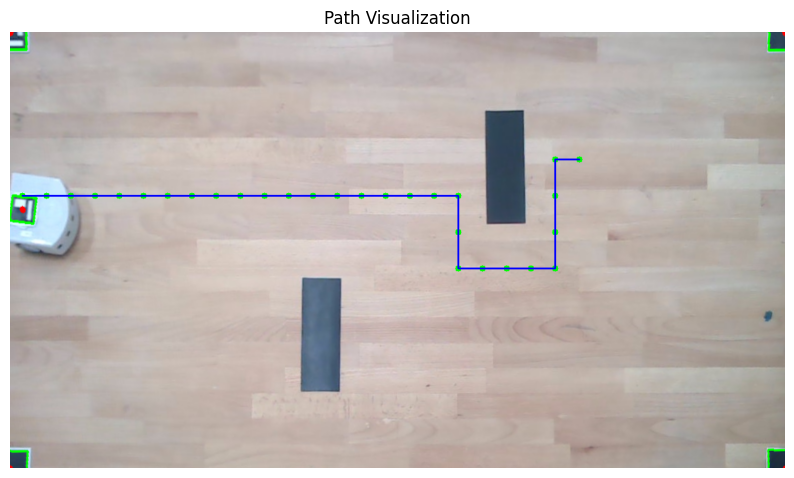

In [218]:


def path_visualization_on_normalized(normalized_image, path, block_width, block_height):
    """
    Visualize the path on the normalized image using matplotlib.
    """
    # Create a copy of the normalized image
    overlay_image = normalized_image.copy()

    if path:
        path_centers_pixels = []
        for row, col in path:
            # Calculate the center of the grid cell in pixels
            center_x_pixels = int((col + 0.5) * block_width)
            center_y_pixels = int((row + 0.5) * block_height)
            path_centers_pixels.append((center_x_pixels, center_y_pixels))

            # Draw the center point
            cv2.circle(overlay_image, (center_x_pixels, center_y_pixels), 5, (0, 255, 0), -1)

        # Draw lines connecting the centers
        for i in range(len(path_centers_pixels) - 1):
            cv2.line(
                overlay_image,
                path_centers_pixels[i],
                path_centers_pixels[i + 1],
                (255, 0, 0),
                2,
            )

    # Convert the image to RGB for matplotlib
    overlay_image_rgb = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB)
    return overlay_image_rgb



# Compute the shortest path
path = astar(costmap, start_grid, goal_grid)

if not path:
    print("No path found!")
else:
    print(f"Path found: {path}")

    # Visualize the path on the normalized image
    overlay_image_rgb = path_visualization_on_normalized(normalized_image, path, block_width, block_height)

    # Display the image with the path
    plt.figure(figsize=(10, 6))
    plt.imshow(overlay_image_rgb)
    plt.axis("off")
    plt.title("Path Visualization")
    plt.show()


### Removing waypoint

As you'll see later, based on our control algorithm, it is more efficient to only keep the waypoints that are the vertices of our path. So we developed an algorithm for this purpose. Let's assume that we have $N$ points $p_1, p_2, \cdots, p_n$. We add $p_0=p_1$ and $p_{n+1}=p_n$ in our set of points $\mathcal{P} \subset \mathbb{R}^2$. We define our first difference operator as :

$$
    \forall i \in \left\{0,\cdots,N\right\}, \ \Delta_{i,i+1} = p_{i+1} - p_i
$$

We also introduce a second order difference operator : 

$$
    \forall i \in \left\{1,\cdots,N\right\}, \ \Delta_{i-1,i,i+1}^{(2)} = \Delta_{i,i+1} - \Delta_{i-1,i}
$$

It appears that when there is a change in direction at the point $p_j$ then $\Delta_{j-1,j,j+1} \neq 0$. So we compute all the second order difference operator and we look at the ones that are non zero. They give us the point that we have to keep.

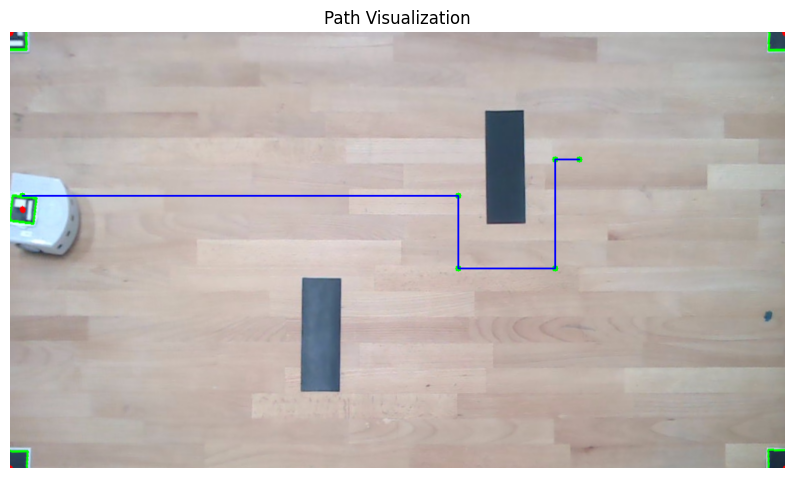

In [219]:
P = np.array(path)

# Compute differences between consecutive points
Pp = np.diff(P, axis=0)
# Compute delta (differences of Pp)
delta = np.diff(Pp, axis=0)
# Identify indices where delta equals 0 (indicating collinearity)
indices_to_remove = np.where((delta == 0).all(axis=1))[0] + 1
# Remove the intermediate points
P2 = np.delete(P, indices_to_remove, axis=0)

# Convert P2 to a list of tuples (row, col)
P2_tuples = [tuple(point) for point in P2]

# Visualize the path on the frame
if len(P2_tuples) > 0:  # Check if P2_tuples is not empty
    overlay_image_rgb = path_visualization_on_normalized(normalized_image, P2_tuples, block_width, block_height)

    # Display the image with the path
    plt.figure(figsize=(10, 6))
    plt.imshow(overlay_image_rgb)
    plt.axis("off")
    plt.title("Path Visualization")
    plt.show()
else:
    print("No path to visualize.")

### Obstacle detection 


We query the vars every 0.1 seconds and we are check if the horizontal proximity sensors detect anything.
self.ratio = (5-1) / (4003 - 1455)
intensity at 5 cm == 1455 and intensity at 1 cm is 4003 we can't detect relayably at more than 5cm. We return the distance for each sensor and its associated angle relative to robot

#### Updating the costmap

When the robot detects an obstacle from one of its sensor, we want to update the costmap. The schema below presents the problem :

![Schema of the line problem](./img/ligne.png)


The parameters are :

- $\theta$ is the yaw of the robot
- $\beta$ is the relative angle between the robot and the obstacle
- $\gamma = \theta + \beta$ gives the angle of the direction of the normal vector of the line that we want to turn into an obstacle
- $\mathbf{n_{\gamma}}$ is the normal vector
- $\mathbf{n_{\gamma}^{\perp}}$ is the direction vector of the line
- $b$ is the half-length of the obstacle wall we want to add
- $z_o = (x_o,y_o)^T$ is the position of the obstacle
- $z_{e, \pm}$ are the extremal points of the line segment of the obstacle

The normal and direction vectors of the line are given by the following formula :

$$
    \mathbf{n_{\gamma}} = \begin{pmatrix} \cos \gamma \\ \sin \gamma \end{pmatrix} \quad \text{and} \quad \mathbf{n_{\gamma}^{\perp}} = \begin{pmatrix} - \sin \gamma \\ \cos \gamma \end{pmatrix}
$$

So the extremal points are simply computed as :

$$
    z_{e, \pm} = z_o \pm b \ \mathbf{n_{\gamma}^{\perp}}
$$

Now that we have the extremal points, we can update our costmap using [Bresenham's line algorithm](https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm).

## Run code under to understand bresenham around the center of a costmap

**Press q** to kill the window.

In [220]:
# Initialize parameters
b = 3
gamma = 0
fakeCostmap = np.zeros((12, 32))

def update_gamma(val):
    """Callback function to update the gamma value."""
    global gamma, fakeCostmap
    gamma = val * np.pi / 180  # Convert slider value (degrees) to radians
    update_costmap()

def update_costmap():
    """Update the costmap based on the current gamma value."""
    global fakeCostmap
    fakeCostmap = np.zeros((12, 32))  # Reset the costmap

    vect = np.array([np.cos(gamma), -np.sin(gamma)])
    z0 = np.array(fakeCostmap.shape) / 2
    extremo = (z0 + b * vect, z0 - b * vect)

    # Use Bresenham's line algorithm to find the points
    line_points = list(bresenham(
        int(extremo[0][1]), int(extremo[0][0]),
        int(extremo[1][1]), int(extremo[1][0])
    ))

    # Set the corresponding grid cells to 1
    for x, y in line_points:
        if 0 <= y < fakeCostmap.shape[0] and 0 <= x < fakeCostmap.shape[1]:  # Ensure points are within bounds
            fakeCostmap[y, x] = 1  # Note: (y, x) because NumPy uses row-major order

    # Visualize the updated costmap
    visualize_costmap()

def visualize_costmap():
    """Display the updated costmap using OpenCV."""
    display = (fakeCostmap * 255).astype(np.uint8)  
    display = cv2.resize(display, (320, 120), interpolation=cv2.INTER_NEAREST) 
    cv2.imshow('Costmap Visualization', display)

# Initialize OpenCV window and trackbar
cv2.namedWindow('Costmap Visualization')
cv2.createTrackbar('Gamma (degrees)', 'Costmap Visualization', 0, 360, update_gamma)

update_costmap()

cv2.waitKey(0)
cv2.destroyAllWindows()


## Code to find obstacle wanted 

In [221]:
def getObstaclePosition(self) -> list:
        """
        Calculates the positions of obstacles based on sensor readings.
        The function iterates through 7 sensors, calculates the distance and angle
        for each sensor, and appends the position to a list. If the distance is greater
        than 5, it appends (-1, 0) to indicate no obstacle detected within the threshold.
        Returns:
            list of tuples: A list of tuples where each tuple contains the distance (float) in mm
                            and angle (float) in degrees of the detected obstacle 0 is in front of thymio.
        """
        pos = []
        detected = False
        #7 proximity sensors
        for i in range(7):
            ##if 2 sensors are close to each other link the 2 dots

            prox = self.getProxH()
            angle = self.sensorAngles[list(self.sensorAngles.keys())[i]]
            
            distance = self.ratio * (4003 - list(prox)[i])
            if distance > 2:
                pos.append((-1, 0))
            else:
                detected = True
                #conversion centimeters to millimeters
                pos.append((distance * 10, angle))
        return pos, detected

Once the costmap is updated, we compute the path using A*, exactly as we did before.

# Robot control

## Creation of Thymio wrapper

Most functions have multiple alternatives the idea was to uniformise the thymio use by the team.
The wrapper is in Thymio.py and is very rudimentary, just enough for team use 

## Calibration

For the robot, we had to derive the conversion factor for the speed sensors from Thymio's unit to mm/s as well as the conversion factor for the proximity sensors.

We obtained the conversion factor for the speed sensors by making a little experiment when we let the robot moves forward for a certain time. From there we knew the distance traveled ($d$), the time ($t$) and the average recorded speed of the thymio ($V_{average}$). So the conversion factor ($CF_{speed}$) is simply :

$$
    CF_{speed} = \frac{d}{t} * \frac{1}{V_{average}}
$$

Now the conversion factor of the proximity sensors is computed by making two measurements : we measured the proximity sensor's value at two distances of a white wall. We can then get the delta of distances ($\Delta d$) and the delta of sensor's values ($\Delta S$) to compute the conversion factor ($CF_{\text{prox sensors}}$) :

$$
    CF_{\text{prox sensors}} = \frac{\Delta d}{\Delta S}
$$

## Control Algorithm

Based on the quantities that the thymio measures and control, the simplest is to separate the control in two parts. In a first time, the robot pivots to align with the direction it has to go. In a second time, it translates to a waypoint. Since the robot cannot align and reach the waypoint perfectly, we defined some margins for it that we will see later.

### Rotation control

In the particular case, $u = V_{I_g} = -V_{I_d}$, it is possible to show that the robot only rotates. By setting the state variable $z \in \mathbb{R}$ such that $z=\theta$. We get for the state equation :

$$
    \dot z = \frac{1}{L}u
$$

That can be discretized as :

$$
    z_{k+1} = z_k + \frac{T_s}{L} u_k
$$

We simply use a proportional controller $u_k = -K_{\text{rot}} z_k$ that verifies the following stability criteria :

$$
    \left| 1 - \frac{K_{\text{rot}} T_s}{L} \right| \leq 1 \Leftrightarrow 0 \leq K_{\text{rot}} \leq \frac{2 L}{T_s}
$$

The order sent to the wheel has a saturation :

$$
    u_k = \left\{\begin{aligned} &K_{\text{rot}} \left( \theta_b - \hat \theta_{k|k-1} \right) &\text{ if } \vert u_k \vert \leq u_{max} \\
    & u_{max} &\text{ if } u_k > u_{max} \\
    & -u_{max} &\text{ if } u_k < -u_{max}
    \end{aligned}
    \right.
$$

with $$\theta_b = \arctan_2{\left(\frac{y_b-\hat y_{k|k-1}}{x_b-\hat x_{k|k-1}}\right)}$$ and $(\hat x_{k|k-1},\hat y_{k|k-1},\hat \theta_{k|k-1})$ the predicted state computed by the Kalman filter. $(x_b,y_b)$ are the position of the waypoint and $\theta_b$ is the relative angle between the robot and the waypoint. The computation of $\theta_b$ will get clearer in the next part.

In [222]:
speedConversion = 0.797829 / 2.7
L = 46.75  # mm
Ts = 0.38
K_rotation = L/(8*Ts)

def rotation_control(pos_estimate, xb, yb):
    x_estimate = pos_estimate[0]  # mm
    y_estimate = pos_estimate[1]  # mm
    theta_estimate = pos_estimate[2]  # rad

    theta_b = np.arctan2(yb-y_estimate, xb-x_estimate)  # en rad
    u = K_rotation * (theta_b - theta_estimate)  # mm/s
    u = u/speedConversion
    if u > 225:
        u = 225
    elif u < -225:
        u = -225
    left_motor_target = u  # in Thymio's unit
    right_motor_target = -u  # in Thymio's unit
    return left_motor_target, right_motor_target

### Translation control


In the particular case $u=V_{I_g}=V_{I_d}$, with the state variable $z=x_1$ the discrete equation is :

$$
    z_{k+1} = z_k + T_s u_k
$$

The proportional controller $u_k = -K_{\text{trans}} z_k$ verifies the following stability criteria :

$$
    0 \leq K_{\text{trans}} \leq \frac{2}{T_s}
$$

The order sent to the wheels is the following :

$$
    u_k = \left\{\begin{aligned} &K_{\text{trans}} \left( (x_1)_b - (\hat x_1)_{k|k-1} \right) &\text{ if } \vert u_k \vert \leq u_{max} \\
    & u_{max} &\text{ if } u_k > u_{max} \\
    & -u_{max} &\text{ if } u_k < -u_{max}
    \end{aligned}
    \right.
$$

With $(x_1)_b = \cos \left(\hat \theta_{k|k-1} \right) x_b + \sin \left(\hat \theta_{k|k-1} \right) y_b$ and $(\hat x_1)_{k|k-1}$ the filtered state given by the Kalman filter



In [223]:
K_translation = 1/(8*Ts)

def translation_control(pos_estimate, xb, yb):
    x_estimate = pos_estimate[0]  # mm
    y_estimate = pos_estimate[1]  # mm
    theta_estimate = pos_estimate[2]  # rad
    x1_b = np.cos(theta_estimate) * xb + np.sin(theta_estimate) * yb  # mm
    x1_estimate = np.cos(theta_estimate) * x_estimate + np.sin(theta_estimate) * y_estimate # mm
    u = K_translation * (x1_b - x1_estimate)  # en mm/s
    u = u / speedConversion
    if u > 225:
        u = 225
    elif u < -225:
        u = -225
    left_motor_target = u  # en unité Thymio
    right_motor_target = u  # en unité Thymio
    return left_motor_target, right_motor_target

### Margins control

So for the margins of the control algorithm we defined them as so :

- A square of half-length $l$ is set as the goal around the waypoint $(x_b,y_b)$
- A cone is defined from this square for which the robot should point to

The scheme below presents the problem :

![Image of the margins for the control](./img/marges_cone.png)

#### Margin set waypoint

For numerical efficiency, the margin set around the waypoint $M_w$ can be written as a polytope.

$$
\begin{aligned}
    M_w &= \left\{ \begin{pmatrix}x\\ y \end{pmatrix} \in \mathbb{R}^2 : \vert x - x_b \vert \leq l, \vert y - y_b \vert \leq l   \right\} \\
    &= \left\{ \begin{pmatrix}x\\ y \end{pmatrix} \in \mathbb{R}^2 : \underbrace{\begin{pmatrix}1&0\\-1&0\\0&1\\0&-1 \end{pmatrix}}_{F} \begin{pmatrix}x-x_b\\ y-y_b \end{pmatrix} \leq l \ \mathbf{1} \right\}
\end{aligned}
$$

In [224]:
l = 50 #mm

def robot_close_waypoint(pos_estimate, xb, yb):
        """_summary_
        Return a boolean to say if the robot is in a square with (xb,yb) as center and 2*l as length size
        Args:
            pos_estimate (1D np array with 2 variables): x,y position of the robot in mm
            xb (float): x position of the waypoint
            yb (float): y position of the waypoint
        """
        ones = np.array([1, 1, 1, 1])
        F = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
        pos_waypoint = np.array([xb, yb])

        print("Is the goal reached ?")
        print(all(F @ (pos_estimate - pos_waypoint) <= l * ones))

        if all(F @ (pos_estimate - pos_waypoint) <= l * ones):
            return True
        else:
            return False

#### Margin set cone

The computation of the margin set for the yaw of the waypoint $C_w$ is a little bit more convolved. Based on the schema above, the set is defined as :

$$
    C_w = \left\{ \theta \in \mathbb{R} : \theta_{min} \leq \theta \leq \theta_{max} \right\}
$$

First, we have to compute the vertices of $M_w$. It is straightforward :

In [225]:
def get_vertices_waypoint(xb, yb):
    vertices = np.array(
        [
            [xb + l, yb + l],
            [xb - l, yb + l],
            [xb - l, yb - l],
            [xb + l, yb - l],
        ]
    )
    return vertices

Since we know the position of the robot $(x,y)$ and the position of the vertices of $M_w$, let's call this set $V(M_w)$, we can easily get $\theta_{min}$ and $\theta_{max}$ by solving the following minimization-maximization problem :

$$
\left\{\begin{aligned}
&\theta_{max} = \max \Theta_w \\
&\theta_{min} = \min \Theta_w
\end{aligned}
\right.
$$

Where $\Theta_w$ is defined as :

$$
    \Theta_w = \left\{ \arctan_2 \left( \frac{y_v-y}{x_v-x} \right) : (x_v,y_v) \in V(M_w) \right\}
$$

To ensure that the robot is within the cone, we deine a margin $\gamma \in [0,0.5]$. Let $\delta = \theta_{max} - \theta_{min}$, $\hat \theta_{max} = \theta_{max} - \gamma \delta$ and $\hat \theta_{min} = \theta_{min} + \gamma \delta$. So we can set the margin as :

$$
\begin{aligned}
    \hat \delta &= \hat \theta_{max} - \hat \theta_{min} \\
                &= (1-2 \gamma) \delta
\end{aligned}
$$

In [226]:
coneMargin = 0.05

def get_cone_angles_waypoint(pos_estimate, xb, yb):
    """_summary_
    This function compute the range within which the robot should point before moving to the waypoint
    with a margin
    Args:
        pos_estimate (1D np array with 2 variables): x,y position of the robot in mm
        xb (float): x position of the waypoint
        yb (float): y position of the waypoint
        margin (float) : number between 0 and 1. (1-2*margin) corresponds to the coverage of the angle
        theta_max - theta_min
    """
    vertices = get_vertices_waypoint(xb, yb)
    angles = []
    for vertex in vertices:
        delta = vertex - pos_estimate
        angles.append(np.arctan2(delta[1], delta[0]))
    angles = np.array(angles)
    theta_max = np.max(angles)
    theta_min = np.min(angles)
    delta = theta_max - theta_min
    return theta_max - coneMargin * delta, theta_min + coneMargin * delta

def robot_align_waypoint(theta_estimate, theta_max, theta_min):
    if theta_estimate < theta_max and theta_estimate > theta_min:
        return True
    else:
        return False

# Kalman filter

**Side note** : The Kalman filter is inspired by the course Multivariable Control taught by professor Giancarlo Ferrari Trecate. 🚀

The state vector $z_k \in \mathbb{R}^6$ is defined as so : $z_k = \left( x_k,y_k,\theta_k, \dot x_k, \dot y_k, \dot \theta_k \right)^T$. The equation of evolution is the following :

$$
\begin{aligned}
    z_{k+1} = \underbrace{\begin{pmatrix} I_3 & T_s I_3\\ 0 & I_3 \end{pmatrix}}_{A} &z_k + w \\ (s_c)_k = \underbrace{\begin{pmatrix}x_k\\y_k\\ \theta_k\\\dot x_k \cos{\theta_k} + \dot y_k \sin{\theta_k} \\ L \dot \theta_k\end{pmatrix}}_{g_c(z_k)} + v_c  \quad &\text{ou} \quad (s_{nc})_k = \underbrace{\begin{pmatrix}\dot x_k \cos{\theta_k} + \dot y_k \sin{\theta_k} \\ L \dot \theta_k\end{pmatrix}}_{g_{nc}(z_k)} + v_{nc}
\end{aligned}
$$

Where $w \sim \mathcal{N}(0,\,W)$, $v_c \sim \mathcal{N}(0,\,V_c)$, $v_{nc} \sim \mathcal{N}(0,\,V_{nc})$ and $z_0 \sim \mathcal{N}(\hat z_0,\,\Sigma_0)$ are all independant gaussian random vectors. 

In [227]:
Ts = 0.38 #Define the sampling time before
L = 46.75 #Define before

# ---------------------------------
# The values are arbitrary and just for the purpose of the simulation.
# The class Thymio holds different values that are tailored for real-life applications
#----------------------------------
W = 0.1*np.identity(6)
W_red_trans = 0.1*np.identity(2)
W_red_rot = 0.1*np.identity(2)
V_c = np.diag([0.1,0.1,0.001,20,20])
V_nc = 20 # It is the same for V_theta and V_x_1

A = np.array([[1, 0, 0, Ts, 0, 0],
              [0, 1, 0, 0, Ts, 0],
              [0, 0, 1, 0, 0, Ts],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

def g_c(z):
    theta = z[2]
    s_c=[z[0], # x
        z[1], # y
        z[2], # theta
        z[3]*np.cos(theta) + z[4]*np.sin(theta), # x_dot*cos(theta) + y_dot*sin(theta)
        L*z[5]] # L*theta_dot
    return np.array(s_c)

The Kalman filter has to be able to switch between two states :

- Camera turned on 🎥 $\Longrightarrow$ position + wheels speed measured ($s_c$)
- Camera turned off 📏 $\Longrightarrow$ wheels speed measured ($s_{nc}$)

When the camera is turned off, it appears that the kalman filter works better to either reconstruct the translation or the rotation. Fortunately, the Thymio can only be in one of this two state. So we will further split the Kalman filter to the specific movements : $s_{nc} \Longrightarrow s_{\theta}, s_{x_1}$.

### $\theta$ dynamic

In rotation, the studied system is a reduced version of the one above. The parameters related to the translation ($x,y \dot x, \dot y$) are fixed in this case. So we will keep the values of those four parameters as the one of the latest predicted state before entering this reduced system.

$$
\begin{aligned}
    z_{\theta,k+1} = \begin{pmatrix}
        \theta_k \\ \dot \theta_k
    \end{pmatrix} &= \underbrace{\begin{pmatrix} 1 & T_s \\ 0 & 1 \end{pmatrix}}_{A_{red}} z_{\theta,k} + w_{\theta}\\
    (s_{\theta,nc})_k &= \underbrace{\begin{pmatrix}
        0&L
    \end{pmatrix}}_{C_\theta} z_{\theta,k} + v_{\theta,nc} 
\end{aligned}
$$

Where $z_{\theta}$, $w_{\theta}$, $v_{\theta}$ are the reduced vectors of $z$, $w$ and $v_{nc}$ coming from their scalar entries on $\theta$ and $\dot \theta$.

In [228]:
A_red = np.array([[1, Ts],
                  [0,  1]])
C_rot = np.array([[0, L]])

We will see later that not much will change in the philosophy of the Kalman equations with this reduced formulation. Nonetheless, we shall pay attention that the covariance matrix has also a reduced form as so :

$$
\Sigma_{\theta} = \begin{pmatrix}
        \Sigma_{\theta,\theta} & \Sigma_{\theta,\dot \theta}\\
        \Sigma_{\dot \theta,\theta} & \Sigma_{\dot \theta,\dot \theta}\\
    \end{pmatrix}
$$

Where $\Sigma$ is the covariance matrix of $z$ and $\Sigma_{\theta}$ the one of $z_{\theta}$. After the filtering step, we can put back the scalar entries of the reduced state vector and covariance matrix into the normal ones. For the other parameters, we can set their covariances to zero. Indeed, during the rotation, $\left\{x,y, \dot x, \dot y \right\}$ are deterministic i.e. they are not random variables. So we can set 

$$
\forall i,j \in \left\{x,y, \dot x, \dot y \right\}, \ \Sigma_{ij} = 0
$$

in the main covariance matrix. Now for the covariance between a deterministic variable and a random variable, by setting $\mu$ the expected value of $z$, we can see that :

$$
\begin{aligned}
  \forall (i,j) \in \left\{x,y, \dot x, \dot y \right\} \times \left\{\theta, \dot \theta \right\}, \Sigma_{ij} &= \mathbb{E}[(z_i - \mu_i)(Z_j - \mu_j)] \\
  &= (z_i - \mu_i) \mathbb{E}[(Z_j - \mu_j)] \text{ since $z_i$ is not a random variable}\\ 
  &=0
\end{aligned}
$$

The capital $Z$ is here to emphasize that it is a random variable.

### $x_1$ dynamic

The reconstruction of the translation is more convolved. Looking at the quantities measured of the robot, it feels like that changing the coordinate system is better suited for this task as it will allow us to only reconstruct 2 variables. During translation, $\dot R(\theta) = 0$ so accoring to the change of basis, $\dot X_1 = R(\theta) \dot X_0$ thus :

$$    
z_1 = \begin{pmatrix}
        x_1\\y_1\\\theta\\\dot x_1\\ \dot y_1\\ \dot \theta
    \end{pmatrix} = \underbrace{\begin{pmatrix}
  \begin{matrix} R(\theta) & \begin{matrix} 0 \\ 0 \end{matrix} \\ \begin{matrix} 0 & 0 \end{matrix} & 1 \end{matrix} & \text{\huge 0} \\
  \text{\huge 0} & \begin{matrix} R(\theta) & \begin{matrix} 0 \\ 0 \end{matrix} \\ \begin{matrix} 0 & 0 \end{matrix} & 1 \end{matrix}
\end{pmatrix}}_{P_{1 \rightarrow 0}} z
 $$

Let's note that $P_{1 \rightarrow 0}$ is an orthogonal matrix and that $z = P_{0 \rightarrow 1} z_1 = P_{1 \rightarrow 0}^T z_1$. During translation, $\theta$ and $\dot \theta$ are fixed i.e. there are not random variables. So we can easily compute the covariance matrix of the random vector $z_1$ as so :

$$
\Sigma_1 = P_{1 \rightarrow 0} \Sigma P_{0 \rightarrow 1} \Longleftrightarrow \Sigma = P_{0 \rightarrow 1} \Sigma_1 P_{1 \rightarrow 0}
$$

In [229]:
def P_1_vers_0(theta):
    R_theta = Rotation_theta(theta)
    return np.block([[R_theta, np.zeros((2,4))],
                        [0,0,1,0,0,0],
                        [np.zeros((2,3)), R_theta, np.zeros((2,1))],
                        [np.zeros((1,6))]])

def P_0_vers_1(theta):
    return P_1_vers_0(theta).T

We can finally write the equations of the reduced system :

$$
\begin{aligned}
    z_{x_1,k+1} = \begin{pmatrix}
        x_1 \\ \dot x_1
    \end{pmatrix} &= \begin{pmatrix} 1 & T_s \\ 0 & 1 \end{pmatrix} z_{x_1,k} + w_{x_1}\\
    (s_{x_1,nc})_k &= \underbrace{\begin{pmatrix}
        0&1
    \end{pmatrix}}_{C_{x_1}} z_{x_1,k} + v_{x_1,nc} 
\end{aligned}
$$

In [230]:
C_trans = np.array([[0, 1]])

And for the reduced covariance matrix :

$$
\Sigma_{x_1} = \begin{pmatrix}
        (\Sigma_1)_{x_1,x_1} & (\Sigma_1)_{x_1,\dot x_1}\\
        (\Sigma_1)_{\dot x_1,x_1} & (\Sigma_1)_{\dot x_1,\dot x_1}
    \end{pmatrix}
$$

Here again, the scalar entries of the reduced state vector and covariance matrix are put back into the main one and the other deterministic entries are set to zero. Then $z$ is computed back :

$$
    z = P_{0 \rightarrow 1} z_1
$$

We introduce a boolean *translation_or_rotation* that is set to **True** if the robot is translating and to **False** if it is turning. We can now write $g_{nc}$.

In [231]:
def g_nc(z, translation_or_rotation):
    if translation_or_rotation:
        return C_trans@z
    else:
        return C_rot@z

## Extended Kalman Filter 🤓

We are going to build an extended Kalman filter since the system is not linear. Let ($z_{k \mid k}, \Sigma_{k \mid k}$) the filtered state and ($z_{k+1 \mid k}, \Sigma_{k+1 \mid k}$) the predicted state.

First, let's compute the gradient of the deterministic function of the observed vectors :

$$
\begin{aligned}
    \nabla_{z} g_c(z) &= \begin{pmatrix}1&0&0&0&0&0\\
    0&1&0&0&0&0\\ 
    0&0&1&0&0&0\\ 
    0&0& -\dot x \sin{\theta} + \dot y \cos{\theta}& \cos{\theta} & \sin{\theta}&0\\ 0&0&0&0&0&L
    \end{pmatrix} \\
    \nabla_{z} g_{nc}(z) &= \left\{ \begin{aligned} &C_{\theta} \text{ If rotation}\\
    &C_{x_1} \text{ If translation}
    \end{aligned}\right.
\end{aligned}
$$

In [232]:
def grad_g_c(z):
    theta = z[2]
    x_dot, y_dot = z[3], z[4]
    grad = [[1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
            [0, 0, -x_dot*np.sin(theta) + y_dot*np.cos(theta), np.cos(theta), np.sin(theta), 0],
            [0, 0, 0, 0, 0, L]]
    return np.array(grad)

def grad_g_nc(z, translation_or_rotation):
    if translation_or_rotation:
        return C_trans
    else:
        return C_rot

### Constructing the observed vector

Based on the state of the camera and the measures flowing into the code, we need a function to build the observed vector $s$.

In [233]:
def constructing_s(V_left_measure, V_right_measure, camera_working=False,
                    x_measured=0, y_measured=0, theta_measured=0,                   
                    translation_or_rotation=True):
    if camera_working:
        s_c = np.array([x_measured,y_measured, theta_measured,
                        (V_left_measure + V_right_measure)/2 , (V_left_measure - V_right_measure)/2])
        return s_c
    elif translation_or_rotation:
        s_nc = (V_left_measure + V_right_measure)/2 # Mesure translation
    else:
        s_nc = (V_left_measure - V_right_measure)/2 # Mesure rotation
    return s_nc

### Filtering step - Camera on


$$
\begin{aligned}
\hat C_k &= \nabla_{z} g_c(\hat z_{k|k-1}) \\
V &= V_c\\

\Sigma_{k|k} & = \Sigma_{k|k-1}-\Sigma_{k|k-1}\hat{C}_{k}^{T}(\hat{C}_{k}\Sigma_{k|k-1} \hat{C}_{k}^{T}+V)^{-1} \hat{C}_{k} \Sigma_{k|k-1} \\

L_{k \mid k} &= \Sigma_{k \mid k-1}\hat{C}_{k}^{T}(\hat{C}_{k}\Sigma_{k|k-1}\hat{C}_{k}^{T}+V)^{-1}\\
    
\hat{z}_{k \mid k} &= \hat{z}_{k \mid k-1}+L_{k \mid k} \left((s_{c})_{k}-g_c(\hat{z}_{k \mid k-1})\right)
\end{aligned}
$$

### Filtering step - Camera off

$$
\begin{aligned}
\hat C_k &= \nabla_{z} g_{nc}(\hat z_{k|k-1}) \\
V &= \left\{\begin{aligned}&V_{\theta} \text{ If rotation}\\ &V_{x_1} \text{ If translation}\end{aligned}\right.\\

\Sigma_{k|k-1} &= \left\{\begin{aligned}&\Sigma_{k|k-1,\theta} \text{ If rotation}\\ &\Sigma_{k|k-1,x_1} \text{ If translation}\end{aligned}\right. \\

(s_{nc})_{k} &= \left\{\begin{aligned}& s_{\theta,nc} \text{ If rotation}\\ &s_{x_1,nc} \text{ If translation}\end{aligned}\right. \\ 

(g_{nc})_{k} &= \left\{\begin{aligned}& C_{\theta} \hat{z}_{\theta, k \mid k-1} \text{ If rotation}\\ &C_{x_1} \hat{z}_{x_1, k \mid k-1} \text{ If translation}\end{aligned}\right. \\ 


\Sigma_{k|k} & = \Sigma_{k|k-1}-\Sigma_{k|k-1}\hat{C}_{k}^{T}(\hat{C}_{k}\Sigma_{k|k-1} \hat{C}_{k}^{T}+V)^{-1} \hat{C}_{k} \Sigma_{k|k-1} \\

L_{k \mid k} &= \Sigma_{k \mid k-1}\hat{C}_{k}^{T}(\hat{C}_{k}\Sigma_{k|k-1}\hat{C}_{k}^{T}+V)^{-1}\\
    
\hat{z}_{k \mid k} &= \hat{z}_{k \mid k-1}+L_{k \mid k} \left((s_{nc})_{k}-(g_{nc})_{k}\right)
\end{aligned}
$$

And after the correct entire vector is reconstructed based on the reduced one.

In [234]:
def filtering_step(z_k_k_1, sigma_k_k_1, V_left_measure, V_right_measure, 
                   camera_working=False, x_measured=0, y_measured=0,
                    theta_measured=0, translation_or_rotation=True):
    ### Computing the variables that are dependant on the state of the camera
    s_k = constructing_s(V_left_measure, V_right_measure, camera_working,
                          x_measured, y_measured, theta_measured, 
                          translation_or_rotation)
    C_k = grad_g_c(z_k_k_1) if camera_working else grad_g_nc(z_k_k_1, translation_or_rotation)
    V = V_c if camera_working else V_nc
    # Changing the computation of the filter based on the state of the camera
    ### The camera is on so all the states are reconstructed
    # Changing the computation of the filter based on the state of the camera
    if camera_working:
        g_k = g_c(z_k_k_1)
        ### The filtering step that can be rewritten without any problem
        L_k_k = sigma_k_k_1 @ C_k.T @ np.linalg.inv(C_k @ sigma_k_k_1 @ C_k.T + V)
        sigma_k_k = sigma_k_k_1 - L_k_k @ C_k @ sigma_k_k_1
        z_k_k = z_k_k_1 + L_k_k @ (s_k - g_k)
    ### The thymio is translatign so only the translation is reconstructed
    elif translation_or_rotation:
        ### Changing the frame of coordinates
        theta = z_k_k_1[2]
        z_1_k_k_1 = P_1_vers_0(theta) @ z_k_k_1
        sigma_1_k_k_1 = (
            P_1_vers_0(theta) @ sigma_k_k_1 @ P_0_vers_1(theta)
        )
        ### Creating a reduced state vector and covariance matrix
        z_1_red_k_k_1 = np.array([z_1_k_k_1[0], z_1_k_k_1[3]])  # x1  & x1_dot
        sigma_1_red_k_k_1 = np.array(
            [
                [sigma_1_k_k_1[0, 0], sigma_1_k_k_1[0, 3]],
                [sigma_1_k_k_1[3, 0], sigma_1_k_k_1[3, 3]],
            ]
        )
        g_k = g_nc(z_1_red_k_k_1, translation_or_rotation)
        ### The filtering step can be computed for the reduced system
        L_red_k_k = (
            sigma_1_red_k_k_1
            @ C_k.T
            @ np.linalg.inv(C_k @ sigma_1_red_k_k_1 @ C_k.T + V)
        )
        sigma_1_red_k_k = sigma_1_red_k_k_1 - L_red_k_k @ C_k @ sigma_1_red_k_k_1
        z_1_red_k_k = z_1_red_k_k_1 + L_red_k_k @ (s_k - g_k)
        ### Putting back the reduced vector into the main one as well as the covariance matrix
        z_1_k_k = z_1_k_k_1
        z_1_k_k[0], z_1_k_k[3] = z_1_red_k_k[0], z_1_red_k_k[1]
        sigma_1_k_k = 0*sigma_1_k_k_1
        sigma_1_k_k[0, 0], sigma_1_k_k[0, 3] = (
            sigma_1_red_k_k[0, 0],
            sigma_1_red_k_k[0, 1],
        )
        sigma_1_k_k[3, 0], sigma_1_k_k[3, 3] = (
            sigma_1_red_k_k[1, 0],
            sigma_1_red_k_k[1, 1],
        )
        ### Going back to the original frame
        z_k_k = P_0_vers_1(theta) @ z_1_k_k
        sigma_k_k = P_0_vers_1(theta) @ sigma_1_k_k @ P_1_vers_0(theta)
    ### The thyimio is turning so only the rotation is recontructed
    else:
        ### Extracting theta and theta_dot
        z_red_k_k_1 = np.array([z_k_k_1[2], z_k_k_1[5]])
        sigma_red_k_k_1 = np.array(
            [
                [sigma_k_k_1[2, 2], sigma_k_k_1[2, 5]],
                [sigma_k_k_1[5, 2], sigma_k_k_1[5, 5]],
            ]
        )
        g_k = g_nc(z_red_k_k_1, translation_or_rotation)
        ### The filtering step can be computed for the reduced system
        L_red_k_k = (
            sigma_red_k_k_1
            @ C_k.T
            @ np.linalg.inv(C_k @ sigma_red_k_k_1 @ C_k.T + V)
        )
        sigma_red_k_k = sigma_red_k_k_1 - L_red_k_k @ C_k @ sigma_red_k_k_1
        z_red_k_k = z_red_k_k_1 + L_red_k_k @ (s_k - g_k)
        z_k_k = z_k_k_1
        z_k_k[2], z_k_k[5] = z_red_k_k[0], z_red_k_k[1]
        sigma_k_k = 0*sigma_k_k_1
        sigma_k_k[2, 2], sigma_k_k[2, 5] = sigma_red_k_k[0, 0], sigma_red_k_k[0, 1]
        sigma_k_k[5, 2], sigma_k_k[5, 5] = sigma_red_k_k[1, 0], sigma_red_k_k[1, 1]
    return z_k_k, sigma_k_k

### Prediction step

The filtering step is changes depending on the three different cases. The governing equation is the same for all and is straightforward to write it down :

$$
\begin{aligned}
    \hat z_{k+1|k} &= A \hat z_{k|k}\\
    \Sigma_{k+1|k} &= A \Sigma_{k|k} A^T + W
\end{aligned}
$$

Extra caution is required for when the camera is off. The computation is only done on the reduced system.

In [235]:
def prediction_step(z_k_k, sigma_k_k, camera_working=False, translation_or_rotation=True):
    if camera_working:
        z_k_1_k = A @ z_k_k
        sigma_k_1_k = A @ sigma_k_k @ A.T + W
    elif translation_or_rotation:
        ### Changing the frame of coordinates
        theta = z_k_k[2]
        z_1_k_k = P_1_vers_0(theta) @ z_k_k
        sigma_1_k_k = (
            P_1_vers_0(theta) @ sigma_k_k @ P_0_vers_1(theta)
        )
        ### Creating a reduced state vector and covariance matrix
        z_1_red_k_k_1 = np.array([z_1_k_k[0], z_1_k_k[3]])  # x1  & x1_dot
        sigma_1_red_k_k = np.array(
            [
                [sigma_1_k_k[0, 0], sigma_1_k_k[0, 3]],
                [sigma_1_k_k[3, 0], sigma_1_k_k[3, 3]],
            ]
        )
        # Updating the state
        z_1_red_k_1_k = A_red @ z_1_red_k_k_1
        sigma_1_red_k_1_k = A_red @ sigma_1_red_k_k @ A_red.T + W_red_trans
        ### Putting back the reduced vector into the main one as well as the covariance matrix
        z_1_k_1_k = z_1_k_k
        z_1_k_1_k[0], z_1_k_1_k[3] = z_1_red_k_1_k[0], z_1_red_k_1_k[1]
        sigma_1_k_1_k = 0*sigma_1_k_k
        sigma_1_k_1_k[0, 0], sigma_1_k_1_k[0, 3] = (
            sigma_1_red_k_1_k[0, 0],
            sigma_1_red_k_1_k[0, 1],
        )
        sigma_1_k_1_k[3, 0], sigma_1_k_1_k[3, 3] = (
            sigma_1_red_k_1_k[1, 0],
            sigma_1_red_k_1_k[1, 1],
        )
        ### Going back to the original frame
        z_k_1_k = P_0_vers_1(theta) @ z_1_k_1_k
        sigma_k_1_k = P_0_vers_1(theta) @ sigma_1_k_1_k @ P_1_vers_0(theta)
    else:
        ### Extracting theta and theta_dot
        z_red_k_k = np.array([z_k_k[2], z_k_k[5]])
        print(f'z_red_k_k = {z_red_k_k}')
        sigma_red_k_k = np.array(
            [
                [sigma_k_k[2, 2], sigma_k_k[2, 5]],
                [sigma_k_k[5, 2], sigma_k_k[5, 5]],
            ]
        )
        
        # Updating the state
        z_red_k_1_k = A_red @ z_red_k_k
        print(f"z_red_k_1_k = {z_red_k_1_k}")
        sigma_red_k_1_k = A_red @ sigma_red_k_k @ A_red.T + W_red_rot
        z_k_1_k = z_k_k
        print(f'z_k_1_k avant = {z_k_1_k}')
        z_k_1_k[2], z_k_1_k[5] = z_red_k_1_k[0], z_red_k_1_k[1]
        print(f'z_k_1_k après = {z_k_1_k}')
        sigma_k_1_k = 0*sigma_k_k
        sigma_k_1_k[2, 2], sigma_k_1_k[2, 5] = sigma_red_k_1_k[0, 0], sigma_red_k_1_k[0, 1]
        sigma_k_1_k[5, 2], sigma_k_1_k[5, 5] = sigma_red_k_1_k[1, 0], sigma_red_k_1_k[1, 1]
    
    return z_k_1_k, sigma_k_1_k

## Estimating the covariance matrices

We ran multiple experiments to compute the different covariance matrices. We also try to fine-tune them by hand.

## Simulating the Kalman filter 🚀

Now it is time to simulate the Kalman filter to see how it is working !

<img src="./img/SQUALALA.gif" alt="Squalala" style="display: block;
  margin-left: auto;
  margin-right: auto;
  width: 30%;"/>

### Camera on

For the test, let's keep things simple so we can make a sanity check. Let's assume that the robot is tilted at an angle $\frac{\pi}{4}$ for all its trajectory and that it is moving forward at a speed $V=10$. So for the time evolution we get :

$$
\left\{\begin{aligned}
&x(t) = \frac{V}{\sqrt{2}}t\\
&y(t) = \frac{V}{\sqrt{2}}t\\
&\theta(t) = \frac{\pi}{4}\\
& \dot x(t) = \frac{V}{\sqrt{2}}\\
& \dot Y(t) = \frac{V}{\sqrt{2}}\\
& \dot \theta(t) = 0
\end{aligned}
\right.
$$

In [236]:
Vitesse = 10

z_mean_0 = np.array([0, #mm
                     0, #mm
                     np.pi/4,
                     Vitesse/np.sqrt(2),
                     Vitesse/np.sqrt(2),
                     0])

z_cov_0 = np.diag([0,0,0,0,0,0])

N = 100 # Durée expérience

z=np.zeros((6,N))

z[:,0] = z_mean_0

for i in range(1,N):
    z[:,i] = np.array([i*Ts*Vitesse/np.sqrt(2), 
                       i*Ts*Vitesse/np.sqrt(2),
                       np.pi/4,
                       Vitesse/np.sqrt(2),
                       Vitesse/np.sqrt(2),
                       0])


In [237]:
z_0_minus_1 = z_mean_0

sigma_0_minus_1 = z_cov_0

z_filtered = []
sigma_filtered = []

z_predicted = [z_0_minus_1]
sigma_predicted = [sigma_0_minus_1]

for i in range(N):
    v = np.random.multivariate_normal(np.zeros(5),V_c)
    s = g_c(z[:,i]) + v
    x_observed, y_observed, theta_observed = s[0], s[1], s[2]
    V_left_measured = s[3] + s[4]
    V_right_measured = s[3] - s[4]
    z_k_k, sigma_k_k= filtering_step(z_k_k_1 = z_predicted[-1], 
                                    sigma_k_k_1 = sigma_predicted[-1], 
                                    V_left_measure = V_left_measured, 
                                    V_right_measure = V_right_measured, 
                                    camera_working=True, 
                                    x_measured=x_observed, 
                                    y_measured=y_observed,
                                    theta_measured= theta_observed)
    
    z_filtered.append(z_k_k)
    sigma_filtered.append(sigma_k_k)

    z_k_1_k, sigma_k_1_k = prediction_step(z_k_k, sigma_k_k)
    z_predicted.append(z_k_1_k)
    sigma_predicted.append(sigma_k_1_k)

z_filtered_array = np.array(z_filtered)
z_filtered_array = z_filtered_array.T

z_predicted_array = np.array(z_predicted)
z_predicted_array = z_predicted_array.T

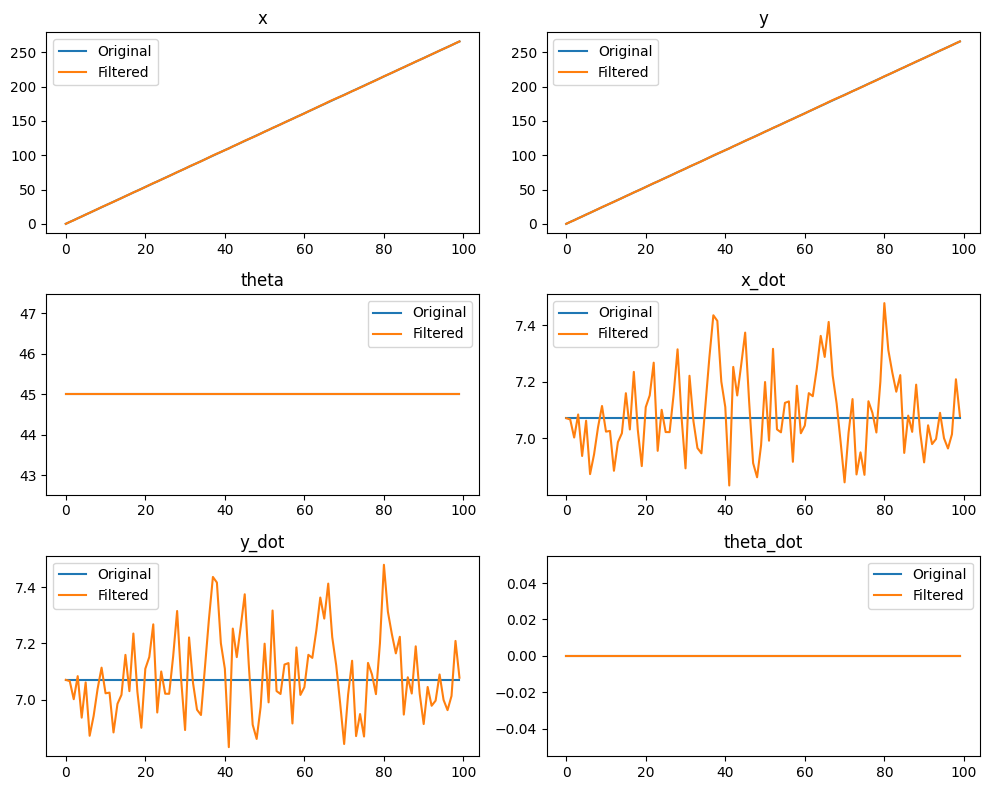

In [238]:
# Define the titles for each subplot
titles = ["x", "y", "theta", "x_dot", "y_dot", "theta_dot"]

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each row of z and z_filtered_array on its corresponding subplot
for i in range(6):
    gamma = 1
    if i == 2 or i == 5:
        gamma = 180/np.pi
    axes[i].plot(gamma*z[i, :], label='Original')
    axes[i].plot(gamma*z_filtered_array[i, :], label='Filtered')
    axes[i].set_title(titles[i])
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

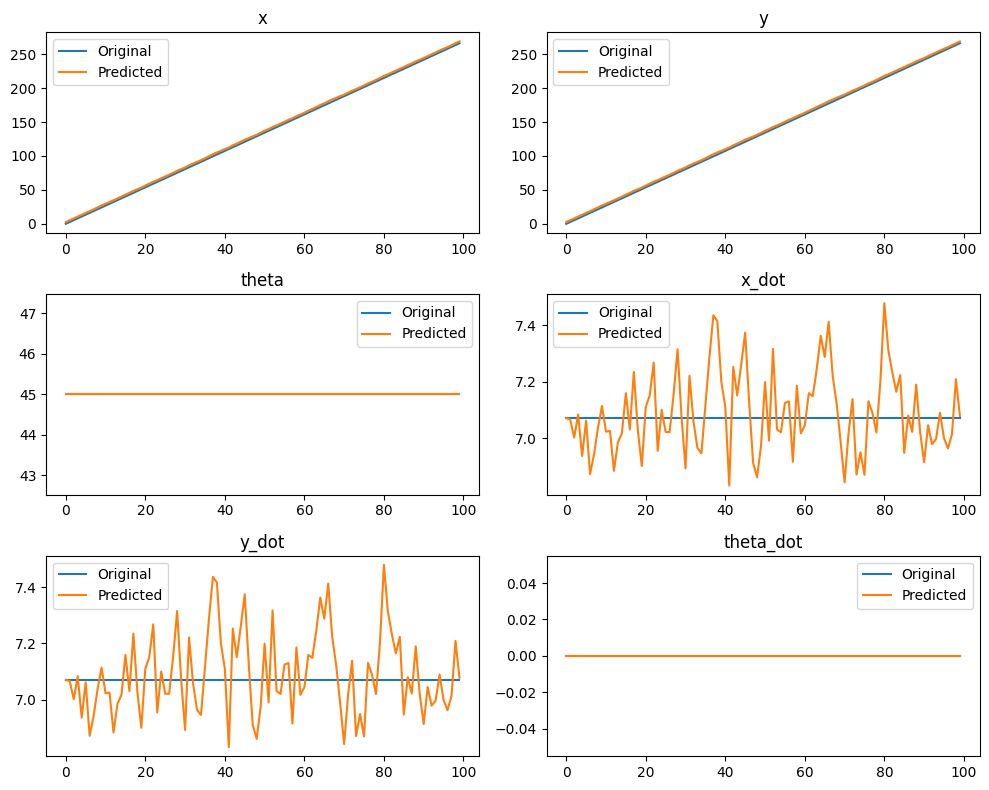

In [239]:
# Define the titles for each subplot
titles = ["x", "y", "theta", "x_dot", "y_dot", "theta_dot"]

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each row of z and z_filtered_array on its corresponding subplot
for i in range(6):
    gamma = 1
    if i == 2 or i == 5:
        gamma = 180/np.pi
    axes[i].plot(gamma*z[i, :], label='Original')
    axes[i].plot(gamma*z_predicted_array[i, 1:], label='Predicted')
    axes[i].set_title(titles[i])
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Camera off - translation

Since the simulation is almost the same for the translation and the rotation, we only show one for simplicity. We decided to demonstrate our Kalman filter on the most complex task i.e. reconstruction.

In [240]:
z_0_minus_1 = z_mean_0

sigma_0_minus_1 = z_cov_0

z_filtered = []
sigma_filtered = []

z_predicted = [z_0_minus_1]
sigma_predicted = [sigma_0_minus_1]

for i in range(N):
    v = np.random.multivariate_normal(np.zeros(5),V_c)
    s = g_c(z[:,i]) + v
    x_observed, y_observed, theta_observed = s[0], s[1], s[2]
    V_left_measured = s[3] + s[4]
    V_right_measured = s[3] - s[4]
    z_k_k, sigma_k_k= filtering_step(z_k_k_1 = z_predicted[-1], 
                                    sigma_k_k_1 = sigma_predicted[-1], 
                                    V_left_measure = V_left_measured, 
                                    V_right_measure = V_right_measured, 
                                    camera_working=False, 
                                    x_measured=0, 
                                    y_measured=0,
                                    theta_measured= theta_observed,
                                    translation_or_rotation=True)
    
    z_filtered.append(z_k_k)
    sigma_filtered.append(sigma_k_k)

    z_k_1_k, sigma_k_1_k = prediction_step(z_k_k, sigma_k_k)
    z_predicted.append(z_k_1_k)
    sigma_predicted.append(sigma_k_1_k)

z_filtered_array = np.array(z_filtered)
z_filtered_array = z_filtered_array.T

z_predicted_array = np.array(z_predicted)
z_predicted_array = z_predicted_array.T


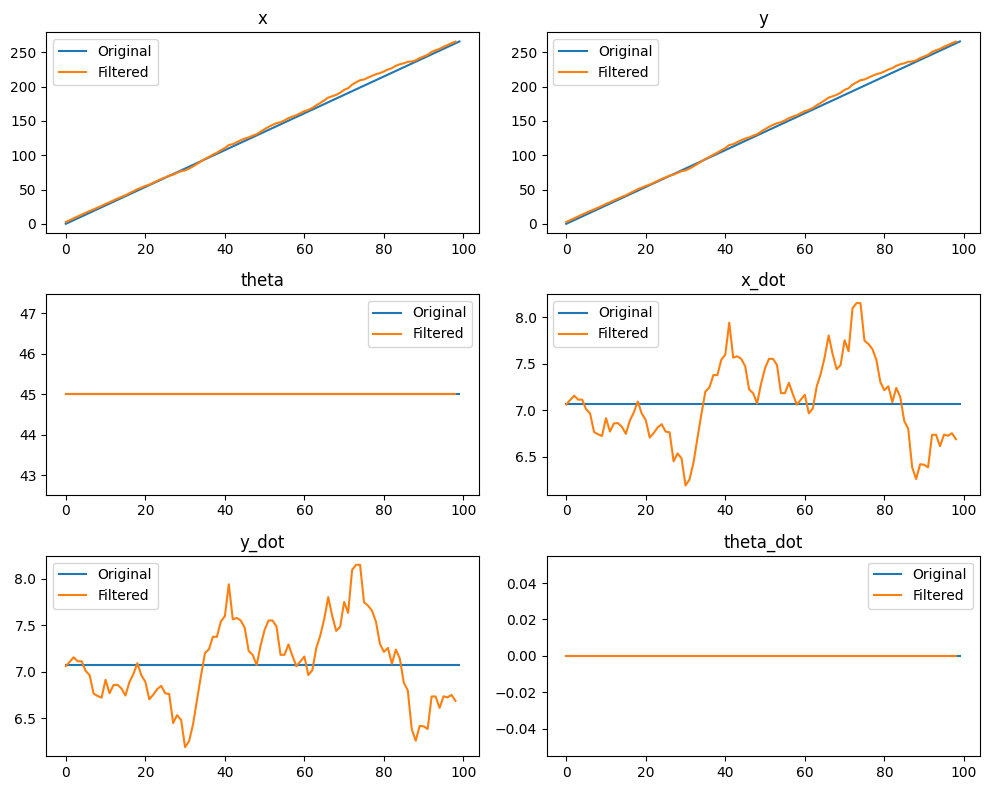

In [241]:
# Define the titles for each subplot
titles = ["x", "y", "theta", "x_dot", "y_dot", "theta_dot"]

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each row of z and z_filtered_array on its corresponding subplot
for i in range(6):
    gamma = 1
    if i == 2 or i == 5:
        gamma = 180/np.pi
    axes[i].plot(gamma*z[i, :], label='Original')
    axes[i].plot(gamma*z_filtered_array[i, 1:], label='Filtered')
    axes[i].set_title(titles[i])
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

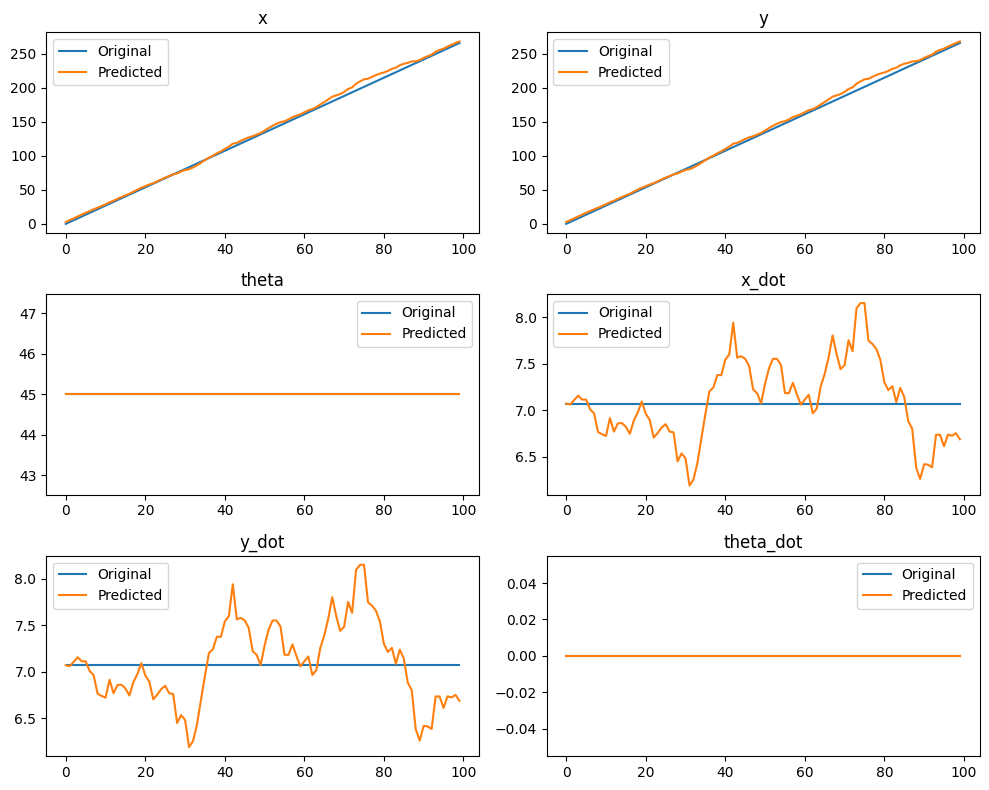

In [242]:
# Define the titles for each subplot
titles = ["x", "y", "theta", "x_dot", "y_dot", "theta_dot"]

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each row of z and z_filtered_array on its corresponding subplot
for i in range(6):
    gamma = 1
    if i == 2 or i == 5:
        gamma = 180/np.pi
    axes[i].plot(gamma*z[i, :], label='Original')
    axes[i].plot(gamma*z_predicted_array[i, 1:], label='Predicted')
    axes[i].set_title(titles[i])
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Running the project

The entire project can be run in the notebook *main.ipynb*.

# Conclusion

This report showed the different parts of our project. We talked about :
- how we implement the computer vision to normalize the play area of the robot and make pose estimation
- how our path planning algorithm work and can provide rapidly the best path
- how we handled the control of the Thymio by coding a wrapper and creating a control algorithm
- how we implemented the Kalman filter and especially how we dealt the pose estimation whithout the camera